### Теория 1:
Предсказание третичной структуры белка по аминокислотной последовательности (первичной структуре)

В рамках соревнования я бы предпочел использовать современный и эффективный метод, основанный на нейронной сети, - ProteinNet. Это опенсорсный проект, поэтому я бы смог свободно его использовать (код на гитхабе).

Говоря о существующих методах восстановления третичной структуры, они достаточно дороги и сложны. Машинное обучение позволяет легко решать сложные задачи вроде этой, имея достаточно много данных. 

В конце прошлого года DeepMind представила алгоритм AlphaFold, который обошел предшественников по эффективности. На основе последовательности аминокислот нейросеть предсказывает расстояния между всеми парами аминокислотных остатков и углы между связями, соединяющими аминокислоты. Позже Мохаммед Аль Курайши представил алгоритм ProteinNet, который работает на основе рекуррентной нейронной сети и предсказывает структуру одного сегмента белка на основе структур сегментов до и после него (типа Bidirectional RNN). Новизна модели в том, что она способна создавать непрерывные предсказания (без пропусков), благодаря тому, что модель связывает локальную и глобальную структуру белка через геометрические единицы.

К сожалению, обучение сети ProteinNet занимает месяцы. Но у нас есть такая вещь, как TransferLearning. Поэтому я бы взял предобученную сетку и дообучил на нужных данных (в рамках соревнования) недельки за 2 :)

Таким образом, я считаю, что нейросетевой подход - будущее биоинформатики. Поэтому пойду на Kaggle решать контесты по распознаванию чего-нибудь биологического, пока мой ProteinNet обучится.

## Task 1

С помощью кода из лабы получим матрицу ДП (все выравнивания же более удобно получить с помощью биопитона)

In [35]:
import numpy as np

def alignProteins(seq1, seq2, printMatrix=True):
    
    # compute dp matrix
    
    n1, n2 = len(seq1), len(seq2)
    dp = np.empty((n1 + 1, n2 + 1), dtype=int)

    dp[:, 0] = np.arange(n1 + 1)
    dp[0, :] = np.arange(n2 + 1)

    for i in range(1, n1 + 1):
        for j in range(1, n2 + 1):
            dp[i, j] = min(dp[i - 1, j - 1] + 2 * int(seq1[i - 1] != seq2[j - 1]) - 1, 
                           dp[i - 1, j] + 1, 
                           dp[i, j - 1] + 1)
            
    if printMatrix:
        print("\t\t\tDP matrix:\n")
        
        seq1_list = [''] + list(seq1)
        seq2_list = ['', ''] + list(seq2)

        print('\t')
        print("\t".join(seq2_list))

        for i in range(n1 + 1):
            print(seq1_list[i], '\t', '\t'.join(list(dp[i].astype(str))))
            
    # back step
    
    i, j = n1, n2     
    ans = [(i, j)]

    while i != 0 and j != 0:
        if dp[i - 1, j - 1] + 2 * int(seq1[i - 1] != seq2[j - 1]) - 1 == dp[i, j]:
            ans.append((i - 1, j - 1))
            i, j = i - 1, j - 1
        elif dp[i - 1, j] + 1 == dp[i, j]:
            ans.append((i - 1, j))
            i, j = i - 1, j
        else:
            ans.append((i, j - 1))
            i, j = i, j - 1

    if i == 0:
        while j != 0:
            ans.append((0, j - 1))
            j -= 1
    elif j == 0:
        while i != 0:
            ans.append((i - 1, 0))
            i -= 1

    ans = list(reversed(ans))
    
    if printMatrix:
        print("\n\t\t\tPath:\n")
        print(ans)
    
    # create output
    
    prev_i, prev_j = 0, 0
    seq1_aligned_list = []
    seq2_aligned_list = []

    for i, j in ans[1:]:        
        if i == prev_i + 1 and j == prev_j + 1:
            seq1_aligned_list.append(seq1[i - 1])
            seq2_aligned_list.append(seq2[j - 1])
        elif i == prev_i + 1 and j == prev_j:
            seq1_aligned_list.append(seq1[i - 1])
            seq2_aligned_list.append('-')
        else:
            seq1_aligned_list.append('-')
            seq2_aligned_list.append(seq2[j - 1])
        prev_i, prev_j = i, j
            
    seq1_aligned = ''.join(seq1_aligned_list)
    seq2_aligned = ''.join(seq2_aligned_list)
            
    return seq1_aligned, seq2_aligned, dp[n1, n2]

In [37]:
seq1 = "CAGCACTTGGATTCTCGG"
seq2 = "CAGCGTGG"

seq1_aligned, seq2_aligned, weight = alignProteins(seq1, seq2)
print("\n\t\t\tAlignment:\n")
print(seq1_aligned)
print(seq2_aligned)
print("\nWeight =", -weight)

			DP matrix:

	
		C	A	G	C	G	T	G	G
 	 0	1	2	3	4	5	6	7	8
C 	 1	-1	0	1	2	3	4	5	6
A 	 2	0	-2	-1	0	1	2	3	4
G 	 3	1	-1	-3	-2	-1	0	1	2
C 	 4	2	0	-2	-4	-3	-2	-1	0
A 	 5	3	1	-1	-3	-3	-2	-1	0
C 	 6	4	2	0	-2	-2	-2	-1	0
T 	 7	5	3	1	-1	-1	-3	-2	-1
T 	 8	6	4	2	0	0	-2	-2	-1
G 	 9	7	5	3	1	-1	-1	-3	-3
G 	 10	8	6	4	2	0	0	-2	-4
A 	 11	9	7	5	3	1	1	-1	-3
T 	 12	10	8	6	4	2	0	0	-2
T 	 13	11	9	7	5	3	1	1	-1
C 	 14	12	10	8	6	4	2	2	0
T 	 15	13	11	9	7	5	3	3	1
C 	 16	14	12	10	8	6	4	4	2
G 	 17	15	13	11	9	7	5	3	3
G 	 18	16	14	12	10	8	6	4	2

			Path:

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3), (6, 4), (7, 4), (8, 4), (9, 4), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (15, 6), (16, 6), (17, 7), (18, 8)]

			Alignment:

CAGCACTTGGATTCTCGG
CAG--C---G----T-GG

Weight = -2


In [53]:
from Bio import pairwise2
alignments = pairwise2.align.globalms("CAGCACTTGGATTCTCGG", "CAGCGTGG", 1, -1, -1, -1)

In [54]:
alignments

[('CAGCACTTGGATTCTCGG', 'CAG--C---G----T-GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAGC-----G----T-GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAG--C--G-----T-GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAGC----G-----T-GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAG--C---G--T---GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAGC-----G--T---GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAG--C--G---T---GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAGC----G---T---GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAG--C---G-T----GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAGC-----G-T----GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAG--C--G--T----GG', -2.0, 0, 18),
 ('CAGCACTTGGATTCTCGG', 'CAGC----G--T----GG', -2.0, 0, 18)]

Веса равны -2

## Task 2

## Task 3

In [28]:
from Bio import SeqIO

SeqIO.convert('cl.fq','fastq','result.fasta','fasta')

250

## Task 4

In [49]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import IUPAC

In [63]:
my_seq = Seq("GGATCGTAGCCTA", IUPAC.unambiguous_dna)
print("3'-" + my_seq.complement() + "-5'")

3'-CCTAGCATCGGAT-5'


## Task 5

In [59]:
def delta(x,y):
    return 0 if x == y else 1

def M(seq1,seq2,i,j,k):
    return sum(delta(x,y) for x,y in zip(seq1[i:i+k],seq2[j:j+k]))

def makeMatrix(seq1,seq2,k):
    n = len(seq1)
    m = len(seq2)
    return [[M(seq1,seq2,i,j,k) for j in range(m-k+1)] for i in range(n-k+1)]

def plotMatrix(M,t, seq1, seq2, nonblank = chr(0x25A0), blank = ' '):
    print(' |' + seq2)
    print('-'*(2 + len(seq2)))
    for label,row in zip(seq1,M):
        line = ''.join(nonblank if s < t else blank for s in row)
        print(label + '|' + line)

def dotplot(seq1,seq2,k = 1,t = 1):
    M = makeMatrix(seq1,seq2,k)
    plotMatrix(M, t, seq1,seq2) #experiment with character choice

seqx = "GCTAGTCAGATCTGACGCTA"
seqy = "GATGGTCACATCTGCCGC"
dotplot(seqx,seqy)

 |GATGGTCACATCTGCCGC
--------------------
G|■  ■■        ■  ■ 
C|      ■ ■  ■  ■■ ■
T|  ■  ■    ■ ■     
A| ■     ■ ■        
G|■  ■■        ■  ■ 
T|  ■  ■    ■ ■     
C|      ■ ■  ■  ■■ ■
A| ■     ■ ■        
G|■  ■■        ■  ■ 
A| ■     ■ ■        
T|  ■  ■    ■ ■     
C|      ■ ■  ■  ■■ ■
T|  ■  ■    ■ ■     
G|■  ■■        ■  ■ 
A| ■     ■ ■        
C|      ■ ■  ■  ■■ ■
G|■  ■■        ■  ■ 
C|      ■ ■  ■  ■■ ■
T|  ■  ■    ■ ■     
A| ■     ■ ■        


На точечном графике можно видеть четкие диагональные линии, что свидетельствует о похожести последовательностей (тут даже почти есть четкая главная диагональ, что говорит о сильной схожести)

## Task 7

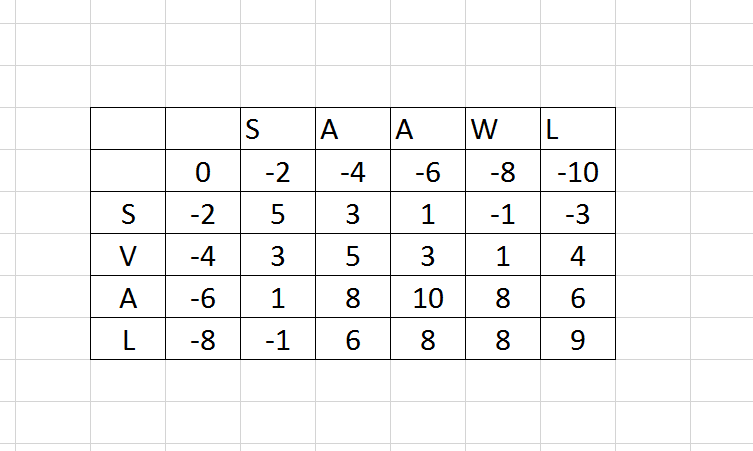

(примерно так, мог немного напутать с поиском по треугольной табличке)

## Task 13.1

In [62]:
seq1 = "AACGTTAC"
seq2 = "CGATAAC"

seq1_aligned, seq2_aligned, weight = alignProteins(seq1, seq2)
print("\n\t\t\tAlignment:\n")
print(seq1_aligned)
print(seq2_aligned)
print("\nWeight =", -weight)

			DP matrix:

	
		C	G	A	T	A	A	C
 	 0	1	2	3	4	5	6	7
A 	 1	1	2	1	2	3	4	5
A 	 2	2	2	1	2	1	2	3
C 	 3	1	2	2	2	2	2	1
G 	 4	2	0	1	2	3	3	2
T 	 5	3	1	1	0	1	2	3
T 	 6	4	2	2	0	1	2	3
A 	 7	5	3	1	1	-1	0	1
C 	 8	6	4	2	2	0	0	-1

			Path:

[(0, 0), (1, 0), (2, 0), (3, 1), (4, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7)]

			Alignment:

AACG-TTAC
--CGATAAC

Weight = 1


## Task 14

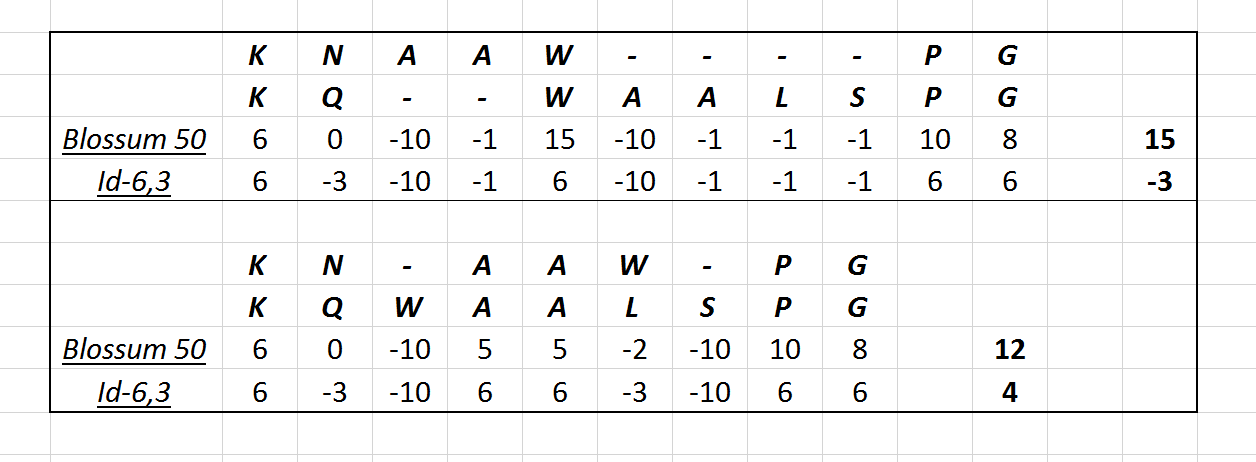